# Linear Regression Analysis
---
**Research question**: "How many friends does a person have based on how much time they spend alone, post online, and whether they go outside and attend social events?"

I want to estimate how many friends a person may have based on time spent alone, how often they post online, and whether they attend social events when going outside (interaction).

$y = Friend\ Circle\ Size$

$\beta_0 = Intercept$

$\beta_1 = Time\ spent\ alone$

$\beta_2 = Post\ frequency$

$\beta_3 = Going\ outside$

$\beta_4 = Social\ event\ attendance$

$$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_2*\beta_3$$

**NOTE:**
- Each survey item scale may be normally distributed, but when combined may form a non-normally distributed dataset.
    - We care about the error term being normally distributed ($\epsilon \sim N(0, \sigma^2))$.
    - We can standardize the survey scales to be proportions: $\frac{x}{max(x)}$

In [424]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from enum import Enum
import seaborn as sns

In [425]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

## Transform Data
The data is not normally distributed and will need to be transformed in some way. We can scale predictors as proportions $\frac{x}{max(x)}$, as each predictor has a different survey scale range (0-5, 0-7, 0-11, etc). Or we can apply natural log or square root operations to each predictor.

In [426]:
# Apply transformation to each variable

def transform(dataframe):
    for column in predictors:
        # Get proportion of responses.
        dataframe[column] = dataframe[column] / max(pre_df[column])

        # Apply log transform
        # dataframe[column] = np.where(dataframe[column] > 0, np.log(dataframe[column]), np.nan)

        # Apply square root transformation
        # dataframe[column] = np.sqrt(dataframe[column])

## (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [427]:
class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return pre_df[pre_df["Personality"] == personality.value[0]]
    return pre_df

pre_df = switch_personality()

In [428]:
train_df = pre_df.sample(frac=0.8, random_state=1863)
transform(train_df)
test_df = pre_df.drop(train_df.index)
transform(test_df)

### Observe Frequency Distribution

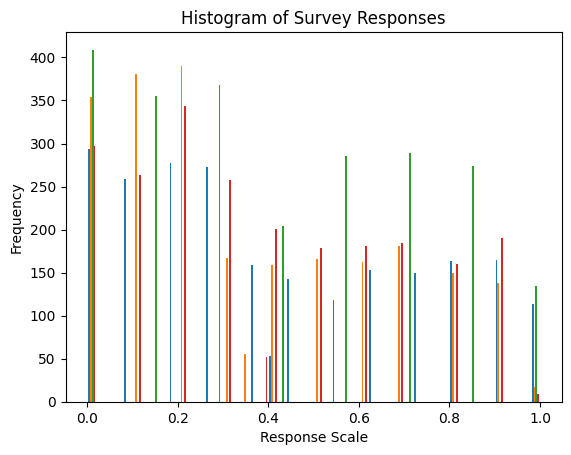

In [429]:
scales = train_df[predictors]

plt.hist(scales, bins=50)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")
plt.show()

## Manual Linear Regression

In [430]:
# See: https://ayoakin.medium.com/linear-regression-from-scratch-using-matrices-991df6e28f62

'''
X = train_df[predictors].copy()
X["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]
y = train_df[["Friends_circle_size"]].copy()

# Append column of 1s
X["Intercept"] = 1

# Transpose
X_T = X.T

# Calculate beta 1 using matrix form
B = np.linalg.inv(X_T @ X) @ (X_T @ y)

B.index = X.columns

# Compute predictions of y-hat using beta 1
predictions = X @ B

# Calculate Sum of Squares
SSR = ((y - predictions) ** 2).sum()
# Calculate Sum of Squares total
SST = ((y - y.mean()) ** 2).sum()
# Calculate R^2
R2 = 1 - (SSR / SST)

residuals = y - predictions

print("\nR-Squared: {}".format(R2.iloc[0]))
B, residuals.head()
'''

'\nX = train_df[predictors].copy()\nX["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]\ny = train_df[["Friends_circle_size"]].copy()\n\n# Append column of 1s\nX["Intercept"] = 1\n\n# Transpose\nX_T = X.T\n\n# Calculate beta 1 using matrix form\nB = np.linalg.inv(X_T @ X) @ (X_T @ y)\n\nB.index = X.columns\n\n# Compute predictions of y-hat using beta 1\npredictions = X @ B\n\n# Calculate Sum of Squares\nSSR = ((y - predictions) ** 2).sum()\n# Calculate Sum of Squares total\nSST = ((y - y.mean()) ** 2).sum()\n# Calculate R^2\nR2 = 1 - (SSR / SST)\n\nresiduals = y - predictions\n\nprint("\nR-Squared: {}".format(R2.iloc[0]))\nB, residuals.head()\n'

## Linear Regression using `statsmodels`

In [431]:
transformed_df = train_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
]]

model = ols(
    formula='Friends_circle_size ~ Time_spent_Alone + Post_frequency + Going_outside + Social_event_attendance',
    data=transformed_df
).fit()

## Predict Using Test Dataframe

In [432]:
test_df_prediction = test_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Personality"
]]

# Combine scaled test data with predictions
test_df_prediction['Predicted'] = model.predict(test_df_prediction)

In [433]:
from statsmodels.tools.eval_measures import meanabs as mae, mse

y_predicted = test_df_prediction["Predicted"]
y_true = train_df["Friends_circle_size"].iloc[:len(y_predicted)]
print("MAE: {}".format(mae(y_true, y_predicted)))
print("MSE: {}".format(mse(y_true, y_predicted)))
model.summary()

MAE: 4.273782814100549
MSE: 27.80325718028962


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     1005.
Date:                 Tue, 22 Jul 2025   Prob (F-statistic):               0.00
Time:                         22:05:31   Log-Likelihood:                -5472.2
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2315   BIC:                         1.098e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.5178      0.235     14.973      0.000       3.057       3.979
Time_spent_Alone           -2.7947      0.279    -10.034      0.000      -3.341      -2.249
Post_frequency              2.1949      0.316      6.952      0.000       1.576       2.814
Going_outside               3.3598      0.296     11.364      0.000       2.780       3.940
Social_event_attendance     4.1512      0.311     13.349      0.000       3.541       4.761
==============================================================================
Omnibus:                       32.134   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.529
Skew:                           0.260   Prob(JB):                     1.42e-07
Kurtosis:                       2.762   Cond. No.                         9.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot regression model

### OLS Linear Regression with CI and PI
Plot OLS linear regression for each predictor against friend circle size with confidence and predictor intervals.

**NOTE:** Because each predictor influences each other when plotting data points, a linear space of data between the min and max of each predictor was needed to be generated. Additionally, each of the other predictors need to be held constant. This means that this test data is synthetic, but is used for model visualization and is not integrated into the test and train samples.

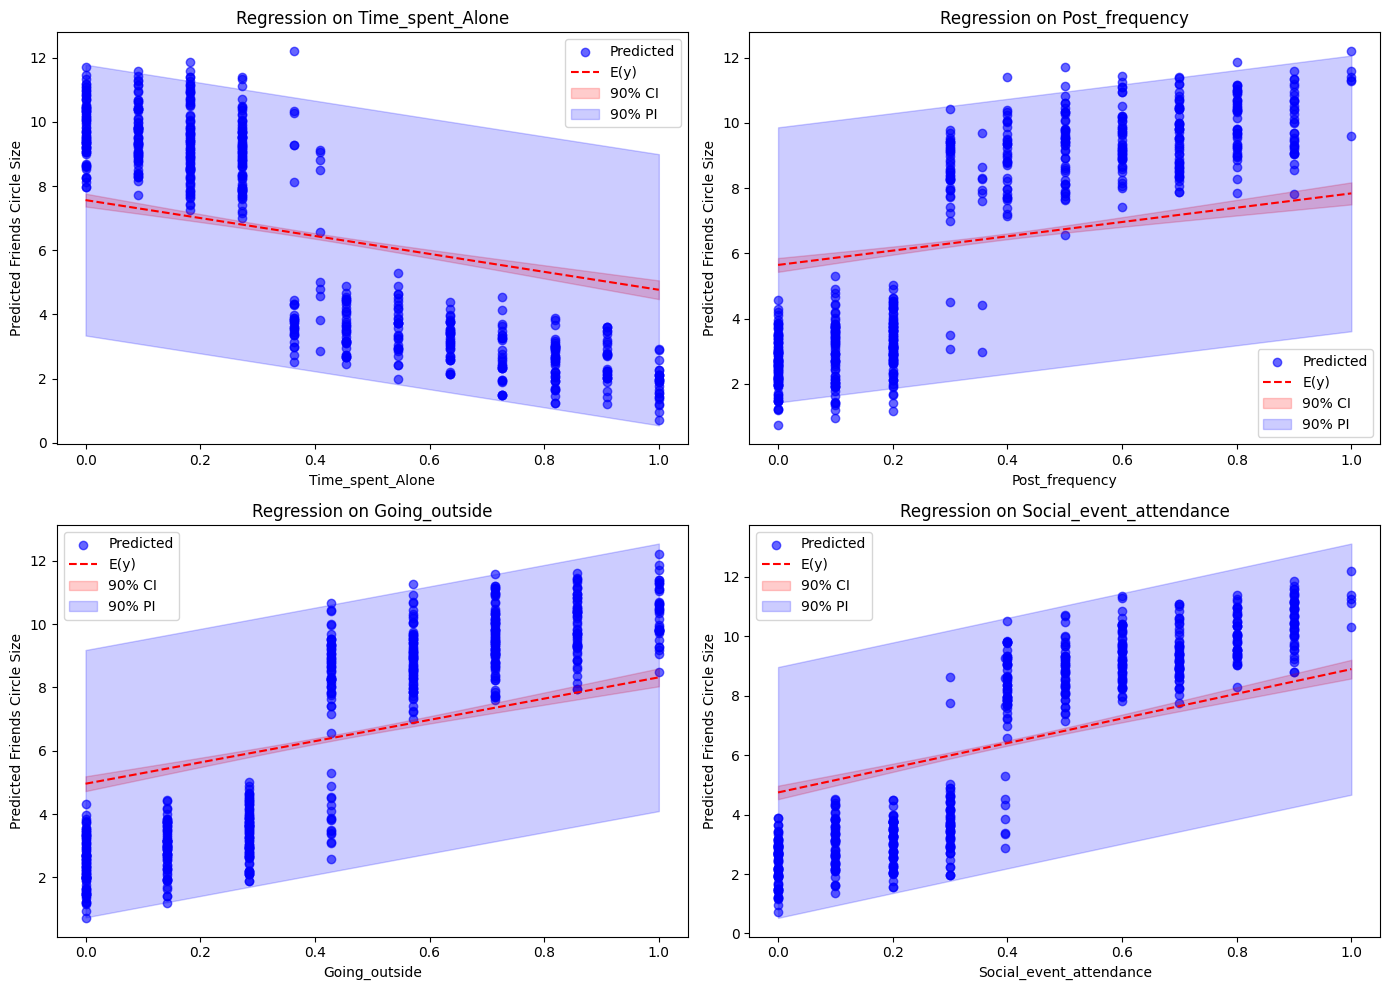

In [441]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]

    # Isolate effects of each predictor and hold other predictors constant (at mean).
    # Generate synthetic data within bounds of predictor; used for testing model
    # Hold all else equal
    x_vals = np.linspace(test_df_prediction[predictor].min(), test_df_prediction[predictor].max(), 100)

    # Create a DataFrame with mean values for other predictors
    fixed_data = pd.DataFrame({
        col: [test_df_prediction[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })
    # fixed_data = fixed_data[predictors]  # Ensure column order

    pred = model.get_prediction(fixed_data)
    pred_summary = pred.summary_frame(alpha=0.10)

    # Plot points
    ax.scatter(
        test_df_prediction[predictor],
        test_df_prediction["Predicted"],
        color="blue",
        alpha=0.6,
        label="Predicted"
    )

    # Regression Line
    ax.plot(
        x_vals,
        pred_summary['mean'],
        color='red',
        label='E(y)',
        linestyle='--'
    )

    # Confidence interval
    ax.fill_between(
        x_vals,
        pred_summary['mean_ci_lower'],
        pred_summary['mean_ci_upper'],
        color='red',
        alpha=0.2,
        label='90% CI'
    )

    # Prediction interval
    ax.fill_between(
        x_vals,
        pred_summary['obs_ci_lower'],
        pred_summary['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='90% PI'
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.legend()

plt.tight_layout()
plt.show()

#### Determine Fitness of Residuals

Residual standard error: 2.559387725978477


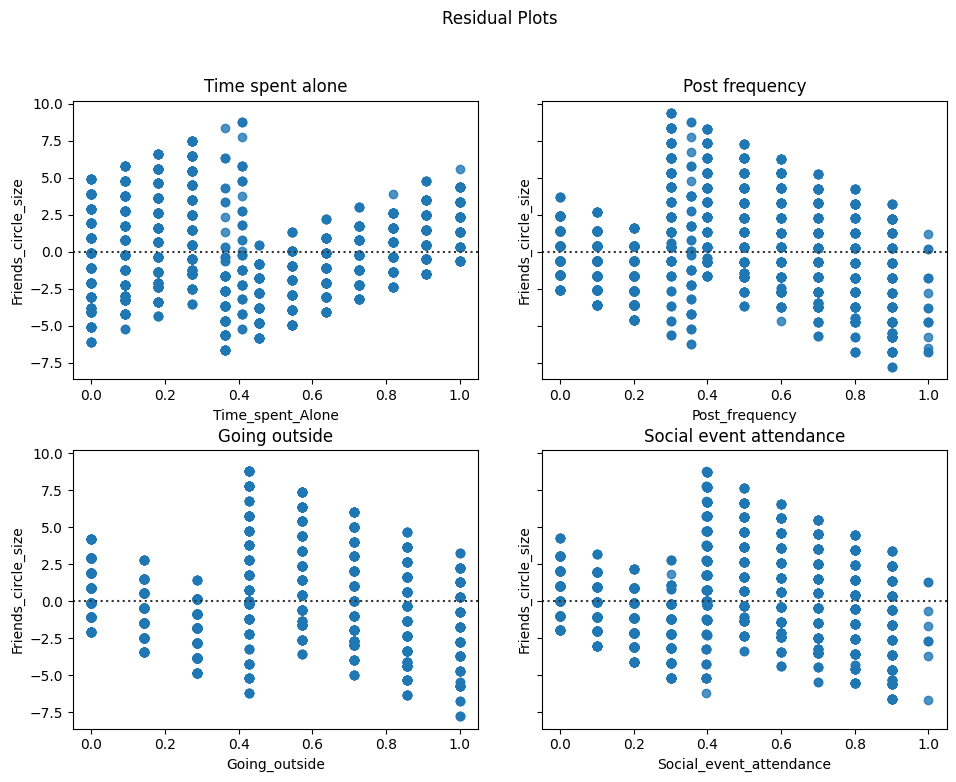

In [435]:
residuals = model.resid

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle("Residual Plots")
fig.tight_layout(pad=3.0)

plots_info = [
    {
        "name": "Time_spent_Alone",
        "title": "Time spent alone",
        "axes": (0, 0)
    },
    {
        "name": "Post_frequency",
        "title": "Post frequency",
        "axes": (0, 1)
    },
    {
        "name": "Going_outside",
        "title": "Going outside",
        "axes": (1, 0)
    },
    {
        "name": "Social_event_attendance",
        "title": "Social event attendance",
        "axes": (1, 1)
    }
]

print("Residual standard error: {}".format(np.std(residuals)))

for plot in plots_info:
    y_axis = plot["axes"][0]
    x_axis = plot["axes"][1]
    position = axes[y_axis, x_axis]
    sns.residplot(transformed_df, x=plot["name"], y="Friends_circle_size", ax=position)
    position.set_title(plot["title"])

### Segmented Linear Regression

#### Find Optimal Breakpoints for Each Predictor

In [436]:
import statsmodels.api as sm

def find_optimal_breakpoint(x, y, min_points=10):
    """
    Try all possible split points, and return the one that minimizes total RSS (residual sum of squares).
    """
    # Sort x in a logical order.
    x_sorted = x.sort_values().reset_index(drop=True)
    possible_splits = x_sorted[min_points:-min_points]

    best_rss = float('inf')
    best_break = None

    for split in possible_splits:
        # Split the data:
        # Left segment: x[mask], y[mask]
        # Right segment: x[~mask], y[~mask]
        mask = x < split
        if mask.sum() < min_points or (~mask).sum() < min_points:
            continue
        
        # Left segment
        model_left = sm.OLS(y[mask], sm.add_constant(x[mask])).fit()
        rss_left = np.sum(model_left.resid ** 2)

        # Right segment
        model_right = sm.OLS(y[~mask], sm.add_constant(x[~mask])).fit()
        rss_right = np.sum(model_right.resid ** 2)

        # Get the smallest residual sum of squares
        total_rss = rss_left + rss_right

        if total_rss < best_rss:
            best_rss = total_rss
            best_break = split

    return best_break

# Create empty dataframe with predictors as columns and first row filled with NA
breakpoints = pd.DataFrame(np.nan, columns=predictors, index=[1])

# Fill first row with optimal breakpoints.
for predictor in predictors:
    breakpoints[predictor] = find_optimal_breakpoint(test_df_prediction[predictor], test_df_prediction["Predicted"])

breakpoints

,Time_spent_Alone,Post_frequency,Going_outside,Social_event_attendance
1,0.363636,0.3,0.428571,0.4


#### Plot Segmented Regressions with CI & PI

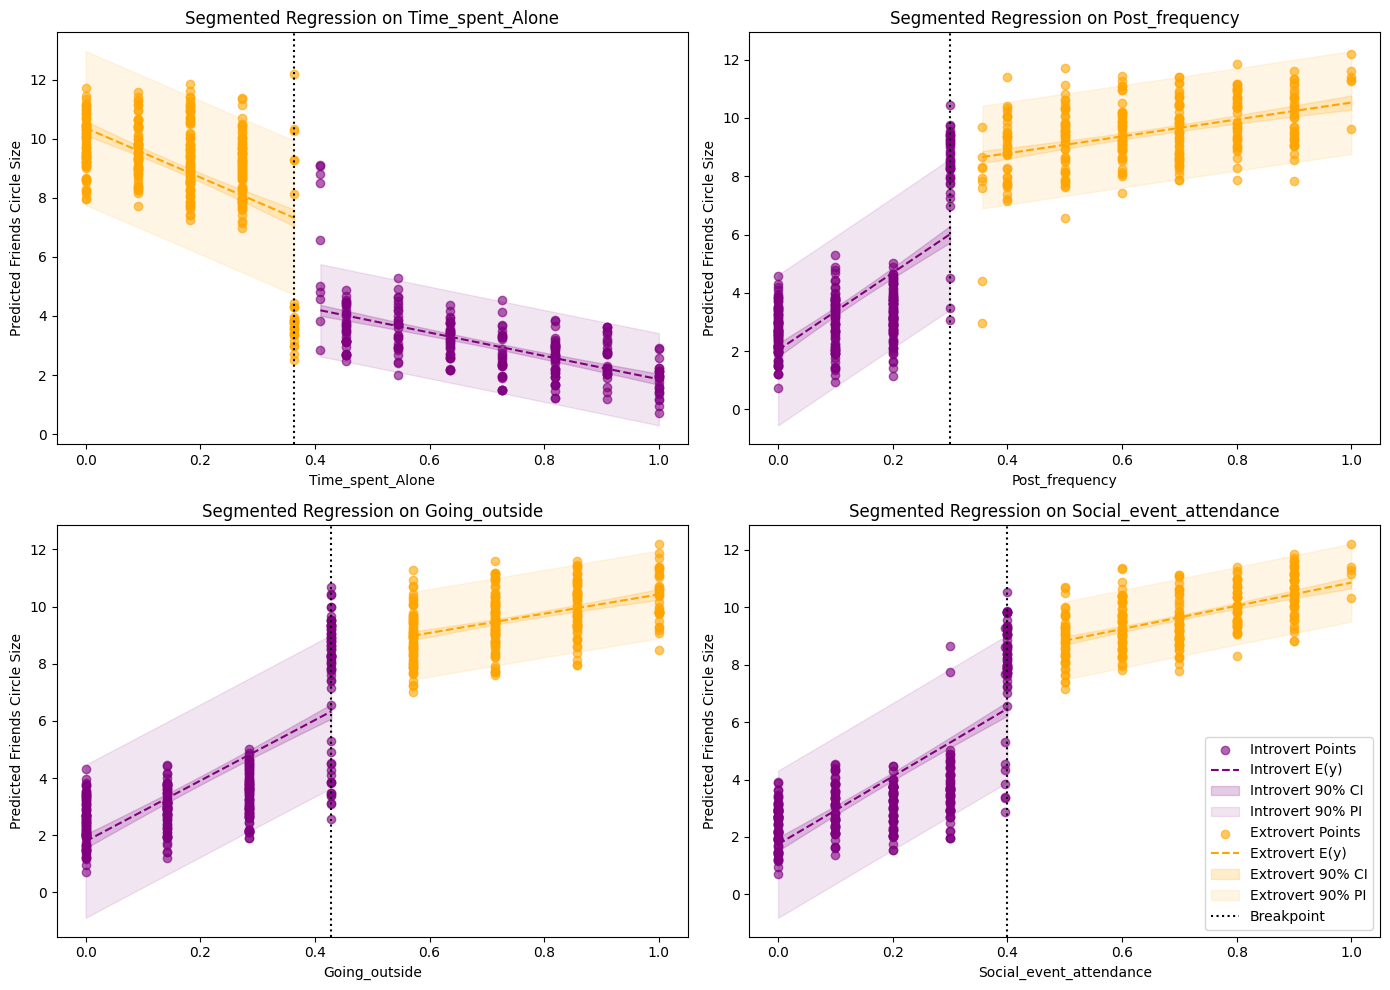

In [437]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

segments = {
    1: {
        "label": Personality.extrovert.value[1],
        "color": "orange"
    },
    0: {
        "label": Personality.introvert.value[1],
        "color": "purple"
    }
}

for i, predictor in enumerate(predictors):
    ax = axs[i]
    bp = breakpoints[predictor][1]

    # Split dataset at breakpoint
    low_mask = test_df_prediction[predictor] <= bp
    high_mask = test_df_prediction[predictor] > bp

    for mask in [low_mask, high_mask]:
        segment_data = test_df_prediction[mask]
        X = segment_data[[predictor]].copy()
        X = sm.add_constant(X)
        y = segment_data["Predicted"]

        model_seg = sm.OLS(y, X).fit()

        # Generate x values in this segment range
        x_vals = np.linspace(X[predictor].min(), X[predictor].max(), 100)
        X_plot = pd.DataFrame({predictor: x_vals})
        X_plot = sm.add_constant(X_plot)

        pred = model_seg.get_prediction(X_plot)
        pred_summary = pred.summary_frame(alpha=0.10)

        # Determine the most common personality type, labeling and coloring as assigned
        personality = segment_data["Personality"].mode()[0]

        # Plot actual points in this segment
        ax.scatter(
            segment_data[predictor],
            segment_data["Predicted"],
            alpha=0.6,
            color=segments[personality]["color"],
            label=f"{segments[personality]['label']} Points"
        )

        # Plot regression line
        ax.plot(
            x_vals,
            pred_summary['mean'],
            color=segments[personality]["color"],
            linestyle='--',
            label=f'{segments[personality]['label']} E(y)'
        )

        # Confidence interval
        ax.fill_between(
            x_vals,
            pred_summary['mean_ci_lower'],
            pred_summary['mean_ci_upper'],
            color=segments[personality]["color"],
            alpha=0.2,
            label=f'{segments[personality]['label']} 90% CI'
        )

        # Prediction interval
        ax.fill_between(
            x_vals,
            pred_summary['obs_ci_lower'],
            pred_summary['obs_ci_upper'],
            color=segments[personality]["color"],
            alpha=0.1,
            label=f'{segments[personality]['label']} 90% PI'
        )

    ax.set_title(f'Segmented Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.axvline(bp, color='black', linestyle=':', label='Breakpoint')

plt.legend()
plt.tight_layout()
plt.show()

### Multicollinearity
Parameters are collinear:
- `Going_outside` = `Social_event_attendance` = `Post_frequency`

## Prediction

In [438]:
from numpy import median

column_range: dict[str, dict[ str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(pre_df[column]),
        "median": median(pre_df[column]),
        "min": min(pre_df[column])
    }

In [446]:
B = model.params
B_df = pd.DataFrame(index=B.index, data=B.values, columns=["Coefficient"])
B_df.to_csv("../data/coefficient_dataframe.csv")

def estimate(x, idx):
    coefficient: float = B.iloc[idx]
    proportion: float = x / column_range[B.index[idx]]["max"]
    return coefficient * proportion

time_alone = lambda x: estimate(x, 1)
post_freq = lambda x: estimate(x, 2)
outside = lambda x: estimate(x, 3)
events = lambda x: estimate(x, 4)
outside_event_attendance = lambda x: estimate(x, 5)

y = time_alone(1) + post_freq(11) + outside(10) + events(10)
y

np.float64(11.111236217015001)

# Application

In [447]:
%%writefile app.py
import streamlit as st
from numpy import median
import pandas as pd

st.title("Friend Circle Size Estimator")
st.markdown(
    """ 
    This app allows for educators to estimate the number a friends a student may have based on
    self-reported time spent alone, posting online, going outside, attending events, and
    attending outside events.
    """
)

pre_df = pd.read_csv("data/preprocessing_dataframe.csv")
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]
column_range: dict[str, dict[str, int | float]] = {}
for column in predictors:
    column_range[column] = {
        "max": max(pre_df[column]),
        "median": median(pre_df[column]),
        "min": min(pre_df[column])
    }

result = {}
for column in predictors:
    humanized_label: str = ' '.join(column.lower().split('_')).capitalize()
    value = st.slider(
        humanized_label,
        min_value=column_range[column]["min"],
        max_value=column_range[column]["max"],
        value=column_range[column]["median"]
    )
    result[column] = value

coef_df = pd.read_csv("data/coefficient_dataframe.csv", index_col=0)


def estimate(x, column):
    coefficient: float = coef_df.loc[column]
    proportion: float = x / column_range[column]["max"]
    return coefficient * proportion


def get_estimate():
    estimated = 0.0
    for column in predictors:
        estimated += estimate(result[column], column)
    return round(estimated.loc["Coefficient"], 2)


if st.button("Estimate"):
    st.text("{} friends".format(get_estimate()))


Overwriting app.py
